## GP Fit on MaunaLoa CO2 Dataset

Importing Libraries

In [19]:
try:
  import distrax
except ModuleNotFoundError:
  %pip install distrax
  import distrax
try:
  import jax
except ModuleNotFoundError:
  %pip install jax 
  import jax

import jax.numpy as jnp
try:
  import matplotlib.pyplot as plt
except ModuleNotFoundError:
  %pip install matplotlib 
  import matplotlib.pyplot as plt

key = jax.random.PRNGKey(42)
jax.config.update("jax_enable_x64", True)

try:
  import GPy
except ModuleNotFoundError:
  %pip install GPy
  import GPy
  
# initial paramters
try:
  from tqdm import tqdm
except ModuleNotFoundError:
  %pip install tqdm
  from tqdm import tqdm


try: 
  import jaxopt
except ModuleNotFoundError:
  %pip install jaxopt
  import jaxopt

### Dataset

In [20]:
import pickle
# Load in the data
with open("/mnt/c/Users/acer/Desktop/Summer2022/IITGN/Gaussian Process/mauna_loa", "rb") as fid:
    print(fid)
    data = pickle.load(fid)
    
print("\nData keys:")
print(data.keys())

print("\nCitation:")
print(data['citation'])

print("\nInfo:")
print(data['info'])

<_io.BufferedReader name='/mnt/c/Users/acer/Desktop/Summer2022/IITGN/Gaussian Process/mauna_loa'>

Data keys:
dict_keys(['X', 'Y', 'Xtest', 'Ytest', 'info', 'citation', 'details', 'files', 'license', 'size', 'urls'])

Citation:
Mauna Loa Data. Dr. Pieter Tans, NOAA/ESRL (www.esrl.noaa.gov/gmd/ccgg/trends/) and Dr. Ralph Keeling, Scripps Institution of Oceanography (scrippsco2.ucsd.edu/).

Info:
Mauna Loa data with 545 values used as training points.


(545, 1) (545, 1)
(185, 1) (185, 1)


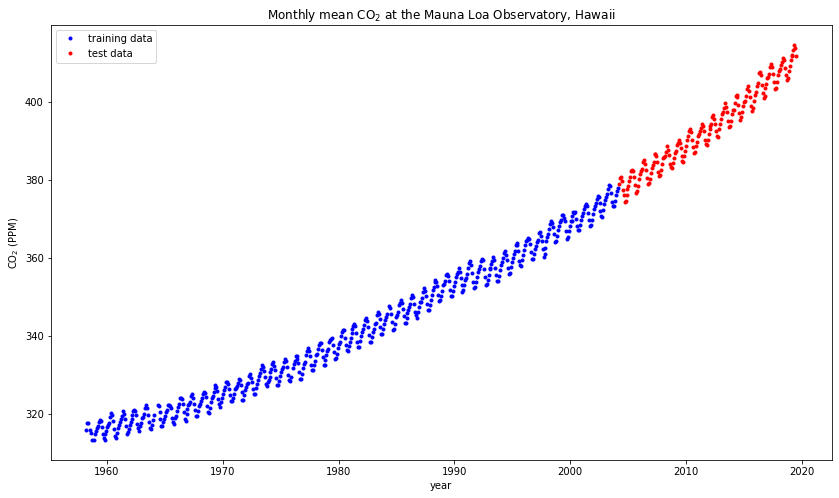

In [35]:
# Training data (X = input, Y = observation)
X, Y = data['X'], data['Y']
print(X.shape,Y.shape)

# Test data (Xtest = input, Ytest = observations)
Xtest, Ytest = data['Xtest'], data['Ytest']
print(Xtest.shape,Ytest.shape)
# Set up our plotting environment
plt.figure(figsize=(14, 8))

# Plot the training data in blue and the test data in red
plt.plot(X, Y, "b.", Xtest, Ytest, "r.")

# Annotate plot
plt.legend(labels=["training data", "test data"])
plt.xlabel("year"), plt.ylabel("CO$_2$ (PPM)"), plt.title("Monthly mean CO$_2$ at the Mauna Loa Observatory, Hawaii");
X = X[::2, :]
Y = Y[::2, :]

### Prior

In [23]:
def prior_samples(x, key):

  def rbf(x, x_star, len_scale, sigmaf):
    return (sigmaf**2)*(jnp.exp(-(x-x_star)**2/(2*(len_scale**2))))  
    
  cov = rbf(X, X.T, 0.1, 1)
  mean_vec = jnp.zeros(X.shape[0])
  prior = distrax.MultivariateNormalFullCovariance(mean_vec,cov)
  f_prior = prior.sample(seed=key, sample_shape = (10,))
  f_prior = f_prior.T
  return f_prior

Sampling from prior

Text(0.5, 1.0, '10 prior samples ')

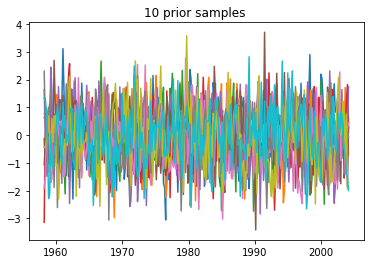

In [36]:
f_prior = prior_samples(X, key)
fig = plt.figure()
plt.plot(X, f_prior)
plt.title("10 prior samples ")
# plt.savefig('prior_sample.png')

### GP Regression

In [25]:
class GP_Regression:

  def rbf(self, x, x_star, len_scale,varf):
    return (varf)*(jnp.exp(-(x-x_star)**2/(2*(len_scale**2))))  
    
  def periodic_kernel(self, x, xstar, len_scale, varf, period):
    return (varf)*(jnp.exp((-1/2*(len_scale**2)) * jnp.square(jnp.sin(jnp.pi * (x-xstar)/period))))
  
  def train(self,theta, X, y):
    self.len_scale = jnp.exp(theta["log_scale"])
    self.varf = jnp.exp(theta["log_varf"])
    k = self.rbf(X,X.T,self.len_scale, self.varf)
    self.k = k + ( jnp.exp(theta["log_vary"]) * jnp.eye(len(X)))
    mean_vec= jnp.zeros(y.shape[0])
    dist = distrax.MultivariateNormalFullCovariance(mean_vec, self.k)
    dist_logprob = dist.log_prob(y.reshape(-1,))
    return -dist_logprob
  

  def posterior(self, X, y, X_test, mu_prior):
    L = jnp.linalg.cholesky(self.k)
    kstar = self.rbf(X, X_test.T, self.len_scale, self.varf)
    kstar_star = self.rbf(X_test, X_test.T, self.len_scale, self.varf)
    # posterior mean
    alpha = jnp.linalg.solve(L.T, (jnp.linalg.solve(L, (y - mu_prior))))
    self.mu_posterior =  mu_prior + jnp.dot(kstar.T, alpha)
    # posterior covarinace
    v = jnp.linalg.solve(L, kstar)
    self.cov_posterior = kstar_star - jnp.dot(v.T, v)
    return self.mu_posterior, self.cov_posterior

In [26]:
def plot_gp(X, m, C, training_points=None):
    """ Plotting utility to plot a GP fit with 95% confidence interval """
    # Plot 95% confidence interval 
    plt.fill_between(X[:,0],
                     m[:,0] - 1.96*jnp.sqrt(jnp.diag(C)),
                     m[:,0] + 1.96*jnp.sqrt(jnp.diag(C)),
                     alpha=0.5)
    # Plot GP mean and initial training points
    plt.plot(X, m, "-")
    plt.legend(labels=["GP fit"])
    
    plt.xlabel("x"), plt.ylabel("f")
    
    # Plot training points if included
    if training_points is not None:
        X_, Y_ = training_points
        plt.plot(X_, Y_, "kx", mew=2)
        plt.legend(labels=["GP fit", "sample points"])

1038310.186664901
(458, 1) (458, 458)


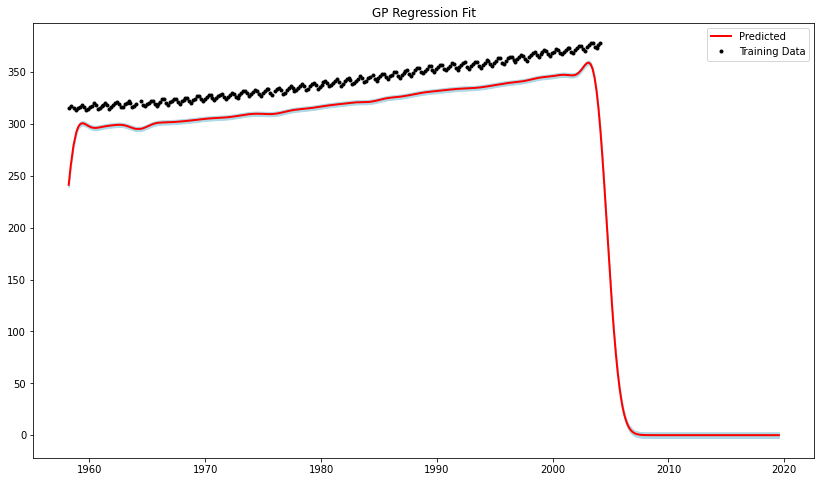

In [27]:
GPR = GP_Regression()

theta_init = {
  "log_varf": jnp.log(1.),
  "log_vary": jnp.log(1.),
  "log_scale": jnp.log(1.)}

#101.502873968226,121454.38823926545, 4.5781156963414125
initial_nll = GPR.train(theta_init,X, Y)
print(initial_nll)
Xnew = jnp.vstack([X, Xtest])
mu_posterior, cov_posterior = GPR.posterior(X, Y, Xnew, 0)
print(mu_posterior.shape, cov_posterior.shape)
 
noise_matrix = jnp.exp(theta_init["log_vary"])*jnp.eye(cov_posterior.shape[0],cov_posterior.shape[1])
plt.figure(figsize=(14, 8))
# plot showing mean and covaraince of 
plt.plot(Xnew, mu_posterior, 'r', lw=2,label='Predicted')
plt.plot(X, Y, ".k", label='Training Data')

plt.fill_between(Xnew.flatten(), 
                 (mu_posterior.flatten() - 1.96*jnp.sqrt((cov_posterior+noise_matrix).diagonal().flatten())),
                 (mu_posterior.flatten() + 1.96*jnp.sqrt((cov_posterior+noise_matrix).diagonal().flatten())),
                  color='lightblue', alpha=1.0)

plt.legend()
plt.title("GP Regression Fit")
# plt.savefig("GP_noiseless_posterior.png")
plt.show()

## Optimizing parameters

### Gradient Descent

It does not work well unless the initializations are close to true values

In [ ]:
# initial paramters
max_iters = int(1000)
lr = 3e-3
nll_iters_final= []
nll_iters_min = []
nll_params = []

theta_init = [{"log_varf": jnp.log(1.), "log_vary": jnp.log(1.),"log_scale": jnp.log(1.)},
              {"log_varf": jnp.log(10.),"log_vary": jnp.log(2.),"log_scale": jnp.log(25.)},
              {"log_varf": jnp.log(5.),"log_vary": jnp.log(1.),"log_scale": jnp.log(15.)},
              {"log_varf": jnp.log(15.),"log_vary": jnp.log(2.),"log_scale": jnp.log(40.)},
              {"log_varf": jnp.log(8.),"log_vary": jnp.log(5.),"log_scale": jnp.log(33.)},
              {"log_varf": jnp.log(20.),"log_vary": jnp.log(9.),"log_scale": jnp.log(10.)}]

# # Using jax.grad
nll_gradient = jax.jit(jax.value_and_grad(GPR.train, argnums = 0))

# Using adam optimizer
import optax

fig, ax = plt.subplots(1,len(theta_init),figsize=(14,6))

for j in range(len(theta_init)): 
  tx = optax.adam(lr)
  opt_state = tx.init(theta_init[j])
  nll_iters = []
  print(GPR.train(theta_init[j],X, Y))

  for i in tqdm(range(max_iters)):
    loss_val,grads = nll_gradient(theta_init[j],X, Y)
    # print(loss_val)
    nll_iters.append(loss_val)
    updates,opt_state = tx.update(grads, opt_state)
    theta_init[j] = optax.apply_updates(theta_init[j], updates)

  ax[j].plot(nll_iters)
  print(theta_init[j])
  print(loss_val)
  nll_iters_final.append(nll_iters[-1])
  nll_params.append(theta_init)


min_index = jnp.argmin(jnp.array(nll_iters_final))
theta_opt = nll_params[min_index]
print(theta_opt)

In [ ]:
GPR = GP_Regression()
Final_nll = GPR.train(theta_opt,X, Y)
print(Final_nll)
Xnew = jnp.vstack([X, Xtest])
mu_posterior, cov_posterior = GPR.posterior(X, Y, Xnew, 0)
print(mu_posterior.shape, cov_posterior.shape)

noise_matrix = jnp.exp(theta_opt["log_vary"])*jnp.eye(cov_posterior.shape[0],cov_posterior.shape[1])
plt.figure(figsize=(14, 8))
# plot showing mean and covaraince of 
plt.plot(Xnew, mu_posterior, 'r', lw=2,label='Predicted')
plt.plot(X, Y, ".k", label='Training Data')

plt.fill_between(Xnew.flatten(), 
                 (mu_posterior.flatten() - 1.96*jnp.sqrt((cov_posterior+noise_matrix).diagonal().flatten())),
                 (mu_posterior.flatten() + 1.96*jnp.sqrt((cov_posterior+noise_matrix).diagonal().flatten())),
                  color='lightblue', alpha=1.0)

plt.legend()
plt.title("GP Regression Fit")
# plt.savefig("GP_noiseless_posterior.png")
plt.show()

### Scipy Minimize (LBFGS)

This works well for initializations as small as (1.,1.,1.)

In [ ]:
theta_init = [{"log_varf": jnp.log(1.), "log_vary": jnp.log(1.),"log_scale": jnp.log(1.)},
              {"log_varf": jnp.log(10.),"log_vary": jnp.log(2.),"log_scale": jnp.log(25.)},
              {"log_varf": jnp.log(5.),"log_vary": jnp.log(1.),"log_scale": jnp.log(15.)},
              {"log_varf": jnp.log(15.),"log_vary": jnp.log(2.),"log_scale": jnp.log(40.)},
              {"log_varf": jnp.log(8.),"log_vary": jnp.log(5.),"log_scale": jnp.log(33.)},
              {"log_varf": jnp.log(20.),"log_vary": jnp.log(9.),"log_scale": jnp.log(10.)}]

values = []
params = []

for i in range(len(theta_init)):
  obj = jax.jit(jax.value_and_grad(GPR.train))
  print(f"Initial negative log likelihood: {obj(theta_init[i],X, Y)[0]}")
  print(f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init[i],X, Y)[1]}")
  solver = jaxopt.ScipyMinimize(fun=GPR.train, method="L-BFGS-B")
  soln = solver.run(theta_init[i], X=X,y=Y)
  print(f"Final negative log likelihood: {soln.state.fun_val}")
  print(f"Final negative log likelihood: {soln.params}")
  values.append(soln.state.fun_val)
  params.append(soln.params)


min_index = jnp.argmin(jnp.array(values))
theta_opt = params[min_index]
print(f"Final negative log likelihood: {values[min_index]}")

In [ ]:
GPR = GP_Regression()
Final_nll = GPR.train(theta_opt,X, Y)
print(Final_nll)
Xnew = jnp.vstack([X, Xtest])
mu_posterior, cov_posterior = GPR.posterior(X, Y, Xnew, 0)
print(mu_posterior.shape, cov_posterior.shape)

noise_matrix = jnp.exp(theta_opt["log_vary"])*jnp.eye(cov_posterior.shape[0],cov_posterior.shape[1])
plt.figure(figsize=(14, 8))
# plot showing mean and covaraince of 
plt.plot(Xnew, mu_posterior, 'r', lw=2,label='Predicted')
plt.plot(X, Y, ".k", label='Training Data')

plt.fill_between(Xnew.flatten(), 
                 (mu_posterior.flatten() - 1.96*jnp.sqrt((cov_posterior+noise_matrix).diagonal().flatten())),
                 (mu_posterior.flatten() + 1.96*jnp.sqrt((cov_posterior+noise_matrix).diagonal().flatten())),
                  color='lightblue', alpha=1.0)

plt.legend()
plt.title("GP Regression Fit")
# plt.savefig("GP_noiseless_posterior.png")
plt.show()